# Invalid procrustes on multilevel data

We need to adjust for multilevel dependencies

In [1]:
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import numpy as np
from graspy.plot import heatmap

from collections import defaultdict
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='notebook', font_scale=1.25)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def simulate_2sample_null(n1, n2=None, d=100, group_std=0.1, seed=None,
                          rand_scale = lambda: np.random.randint(0, 2)*2 - 1):
    """
    Simulates a set of paired observations for a 2-sample test.
    
    n1,n2 : size of the two groups. Are both n1 if n2 is None
    d : dimension of observations
    group_std : standard deviation of normal distribution around group mean
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is None:
        n2 = n1
    mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    X = np.vstack(
        [np.random.normal(mu, group_std, (2,d))  for mu in mus1]  +
        [np.random.normal(mu, group_std, (2,d)) for mu in mus2]
    )
    scales = np.asarray([rand_scale() for _ in range(X.shape[0])])
    X = X * scales[:, np.newaxis]
    return X

def simulate_multiviews_null(n_view_pairs, n, d=100, group_std=0.1, seed=None, dist=np.random.normal,
                             dist_kwargs={'loc':0, 'scale':1}):
    """
    Simulates multivariate gaussian data of shape (n_niews, n, d)
    where sequential pairs in the 1st dimension are correlated
    """
    np.random.seed(seed)

    mus = [dist(**dist_kwargs,size=(n,d)) for i in range(n_view_pairs)]
    X = np.asarray(np.vstack([
        [np.random.normal(mu, group_std), np.random.normal(mu, group_std)] for mu in mus
    ]))
    
    return X

In [11]:
def iterative_alignment(embeddings, n_iters=1):
    target = embeddings[0]
    realigned = [target]
    xfms = []
    # first pass
    for i, embedding in enumerate(embeddings[1:]):
        u, s, v = np.linalg.svd(target.T.dot(embedding), full_matrices=False)
        xfms.append(v.T.dot(u.T))
        realigned.append(embedding.dot(xfms[-1]))

    # get mean target
    # 1. random sampling (doesn't cover all points)
    #    - allows more dense sampling
    #    - keeps coordinates from the real anatomical space
    # 2. mean across subjects
    # multi-pass
    for i in range(1, n_iters):
        index = []
        target = np.mean(realigned, axis=0).squeeze()
        target = np.array(target)
        realigned = []
        xfms = []
        for i, embedding in enumerate(embeddings):
            u, s, v = np.linalg.svd(target.T.dot(embedding), full_matrices=False)
            xfms.append(v.T.dot(u.T))
            realigned.append(embedding.dot(xfms[-1]))
    return realigned, xfms

In [5]:
# Simulation parameters
n_views = 25
n = 1000
d = 100

group_std = 0.1

N_DATASETS = 100
REPS = 250

In [6]:
Y_within = np.asarray([0, 1] * (n_views))
#Y_across = np.hstack(([0] * n1 * 2, [1] * n2 * 2))

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n_views)]).T

test_results = []

In [19]:
for i in range(N_DATASETS):
    if i % 25 == 0:
        print(i, end=' ')
    
    X = simulate_multiviews_null(n_views, n, d)
    
    X_pca = [PCA(n_components=3).fit_transform(x) for x in X]

    X_align, _ = iterative_alignment(X_pca, n_iters=5)

    _, pval = Dcorr().test(
        np.asarray(X_align)[:,:,0],
        Y_within,
        reps=REPS,
        workers=-1,
        #auto=False,
        perm_blocks=blocks_within,
    )
    test_results.append(pval)

0 25 50 75 

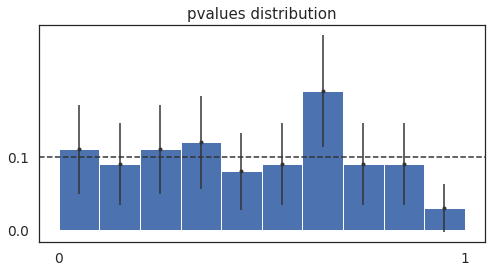

In [20]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)#, sharey=ax)
N = len(test_results)
entries, edges, _ = ax.hist(test_results, bins = np.arange(0,1.1,0.1), weights=np.ones(N)/N, color='b')
# entries = height of each column = proportion in that bin
# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
# errorbars are binomial proportion confidence intervals
ax.errorbar(
    bin_centers, entries,
    yerr = 1.96 * np.sqrt(entries * (1 - entries) / N),
    fmt='.',c='#333333'
)
ax.set_title(f'pvalues distribution')

ax.set_xticks([0,1])

ax.set_yticks([0,0.1])
#ax.set_yticks([0, 0.1, 1])

plt.show()

In [21]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

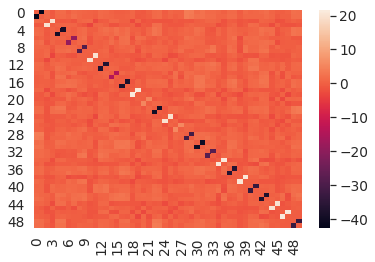

In [27]:
fig = sns.heatmap(
    center_distmat(pairwise_distances(np.asarray(X_pca)[:,:,0], metric="euclidean")),
)

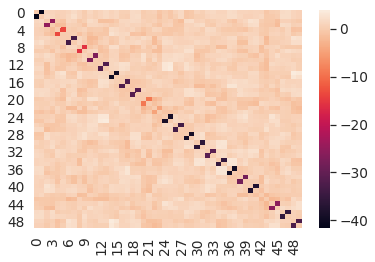

In [25]:
fig = sns.heatmap(
    center_distmat(pairwise_distances(np.asarray(X_align)[:,:,0], metric="euclidean")),
)

In [51]:
test_results_2 = []

In [55]:
rand_scale = lambda: np.random.randint(0, 2)*2 - 1
for i in range(N_DATASETS):
    if i % 25 == 0:
        print(i, end=' ')
    
    X = simulate_multiviews_null(n_views, n, d)
    
    X = [x * np.asarray([rand_scale() for _ in range(x.shape[1])]) for x in X]
    
    X_align, _ = iterative_alignment(X, n_iters=5)

    _, pval = Dcorr().test(
        np.asarray(X_align)[:,:,0],
        Y_within,
        reps=REPS,
        workers=-1,
        #auto=False,
        perm_blocks=blocks_within,
    )
    test_results_2.append(pval)

0 25 50 75 

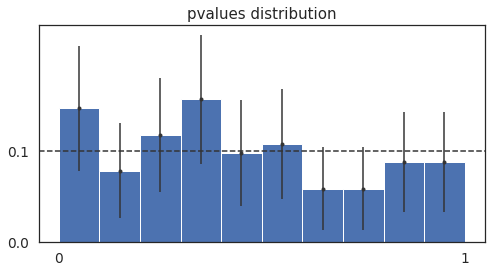

In [56]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)#, sharey=ax)
N = len(test_results_2)
entries, edges, _ = ax.hist(test_results_2, bins = np.arange(0,1.1,0.1), weights=np.ones(N)/N, color='b')
# entries = height of each column = proportion in that bin
# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
# errorbars are binomial proportion confidence intervals
ax.errorbar(
    bin_centers, entries,
    yerr = 1.96 * np.sqrt(entries * (1 - entries) / N),
    fmt='.',c='#333333'
)
ax.set_title(f'pvalues distribution')

ax.set_xticks([0,1])

ax.set_yticks([0,0.1])
#ax.set_yticks([0, 0.1, 1])

plt.show()

### Playing with the real data

In [91]:
from pathlib import Path
import os
import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

In [88]:
datadir = Path("/mnt/ssd3/ronan/data")
dmap_dir = datadir / f"dmap_09-22_aligned"
dmap_dir = datadir / f'dmap_09-04_unaligned'
SOURCE = 'dmap'

In [89]:
if SOURCE == "gcca":
    flag = "_gcca"
    ftype = "h5"
    source_dir = gccadir
elif SOURCE == "dmap":
    flag = "_dmap"
    ftype = "npy"
    source_dir = dmap_dir
else:
    raise ValueError(f"{SOURCE} invalid data key")
groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, subjects_exclude=['073'], as_groups=False
)

In [20]:
groups_0 = groups[:,:,0].reshape(225,18715)

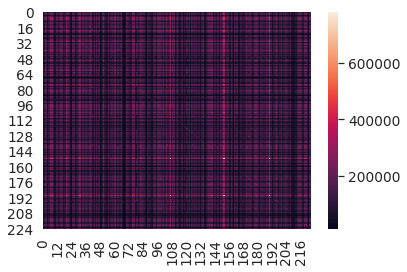

In [21]:
sns.heatmap(groups_0 @ groups_0.T)

(array([ 6., 34., 56., 58., 29., 12., 16.,  7.,  5.,  2.]),
 array([-0.15959391, -0.08289893, -0.00620395,  0.07049103,  0.14718601,
         0.22388099,  0.30057597,  0.37727094,  0.45396593,  0.5306609 ,
         0.6073559 ], dtype=float32),
 <a list of 10 Patch objects>)

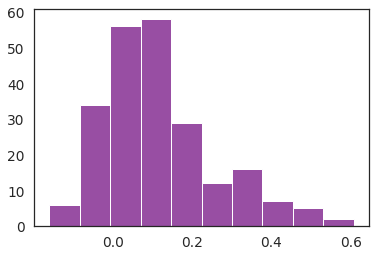

In [22]:
plt.hist(np.mean(groups_0, axis=1))

In [23]:
np.linalg.norm(groups_0, axis=0).shape

(18715,)

In [90]:
for i in range(225):
    sub = groups[i,:,:].reshape(18715,5)
    sub = sub / np.linalg.norm(sub, axis=0)
    print(np.concatenate(sub.T @ sub))

[ 1.0000024   0.03203201 -0.05813803 -0.01837314 -0.00747903  0.03203201
  0.9999977  -0.07895265  0.00135658 -0.02365229 -0.05813803 -0.07895265
  1.0000015   0.02988362  0.00750443 -0.01837314  0.00135658  0.02988362
  1.0000015   0.03428005 -0.00747903 -0.02365229  0.00750443  0.03428005
  1.0000024 ]
[ 1.0000024   0.02060582 -0.00541883 -0.03029065 -0.00922962  0.02060582
  1.0000017   0.00361318  0.00745815  0.02351066 -0.00541883  0.00361318
  1.000003    0.03680468  0.02729655 -0.03029065  0.00745815  0.03680468
  1.0000026   0.01977862 -0.00922962  0.02351066  0.02729655  0.01977862
  1.0000012 ]
[ 1.0000025  -0.07552178  0.00291271  0.0020731  -0.00317323 -0.07552178
  1.0000031  -0.04198812  0.06820814 -0.02667357  0.00291271 -0.04198812
  1.000001    0.02442644  0.01541777  0.0020731   0.06820814  0.02442644
  1.0000049  -0.02012418 -0.00317323 -0.02667357  0.01541777 -0.02012418
  1.0000005 ]
[ 9.9999958e-01 -8.7357489e-03 -1.8229822e-02  2.5024200e-02
  1.4675651e-02 -8.73

  1.0000020e+00]
[ 1.0000011   0.01648319  0.02393306  0.00460165  0.01373692  0.01648319
  1.0000007   0.0725491   0.02074553  0.01590893  0.02393306  0.0725491
  1.0000015  -0.08028276  0.05404387  0.00460165  0.02074553 -0.08028276
  1.0000044  -0.05131522  0.01373692  0.01590893  0.05404387 -0.05131522
  1.0000069 ]
[ 0.99999976  0.02889228 -0.01972798 -0.00122866 -0.01365992  0.02889228
  1.0000012   0.04349772 -0.02924039 -0.00642975 -0.01972798  0.04349772
  1.0000043   0.02554063  0.00102011 -0.00122866 -0.02924039  0.02554063
  1.0000021   0.02358843 -0.01365992 -0.00642975  0.00102011  0.02358843
  0.99999976]
[ 1.0000014   0.03455469 -0.03157353 -0.0148042  -0.00192323  0.03455469
  0.9999994  -0.05267821  0.01139826 -0.00499154 -0.03157353 -0.05267821
  1.0000012  -0.02493171  0.06054327 -0.0148042   0.01139826 -0.02493171
  1.0000021  -0.06935906 -0.00192323 -0.00499154  0.06054327 -0.06935906
  1.0000045 ]
[ 1.0000066  -0.01781907  0.0134607   0.00204798  0.0017184  -0.01

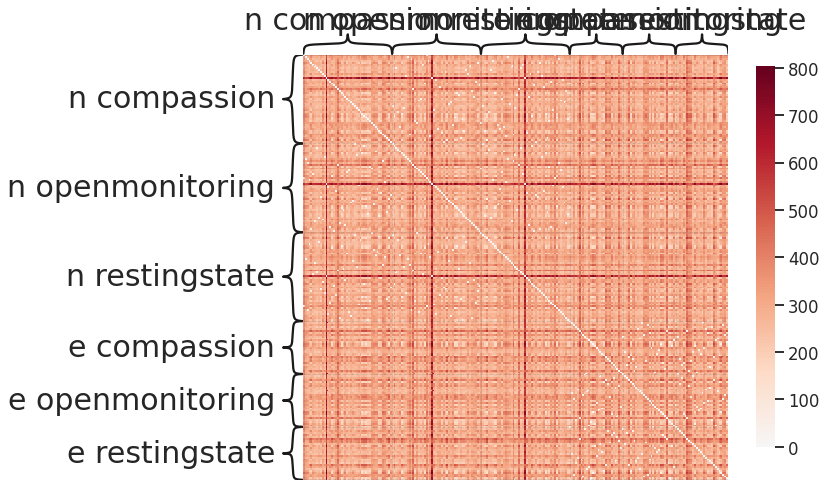

In [31]:
heatmap(pairwise_distances(groups[:,:,0].reshape(225,18715)),
        inner_hier_labels = [a + ' ' + b for a,b in labels])

In [34]:
X_dist_sums = pairwise_distances(groups[:,:,0].reshape(225,18715)).sum(axis=1)

(array([106.,  75.,  25.,  10.,   6.,   0.,   0.,   0.,   1.,   2.]),
 array([ 58817.242,  66890.055,  74962.86 ,  83035.67 ,  91108.484,
         99181.3  , 107254.1  , 115326.914, 123399.73 , 131472.53 ,
        139545.34 ], dtype=float32),
 <a list of 10 Patch objects>)

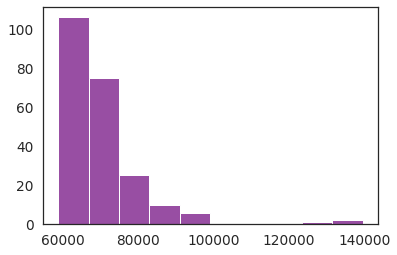

In [35]:
plt.hist(X_dist_sums)

In [39]:
subj_dict = defaultdict(list)
for sub, dist in zip(subjs, X_dist_sums):
    subj_dict[sub].append(dist / np.max(X_dist_sums))

In [40]:
subj_dict

defaultdict(list,
            {'053': [0.46116233, 0.456814, 0.45495802],
             '072': [0.46784517, 0.46273875, 0.4613818],
             '057': [0.5270816, 0.5214455, 0.53349805],
             '063': [0.47621846, 0.48881513, 0.47525042],
             '054': [0.5140053, 0.5188938, 0.5065882],
             '067': [0.4616815, 0.44756532, 0.45967832],
             '055': [0.69696724, 0.65341383, 0.69605654],
             '058': [0.6124133, 0.5648675, 0.63497806],
             '068': [0.59125906, 0.568484, 0.57037634],
             '071': [0.44219398, 0.4318389, 0.43473992],
             '074': [0.50163096, 0.502341, 0.49857837],
             '069': [0.5022004, 0.52395254, 0.5028824],
             '065': [0.46147767, 0.45285696, 0.46813786],
             '059': [0.47717845, 0.4786512, 0.47486514],
             '064': [0.44383037, 0.4433645, 0.44608346],
             '078': [0.57311946, 0.5494395, 0.55547917],
             '077': [0.47103384, 0.46160287, 0.4892153],
             '060'

Subject 002 is an outlier clearly

### Gcca outlier look

In [18]:
datadir = Path("/mnt/ssd3/ronan/data")
gccadir = datadir / f'gcca_07-09-12:06_min_rank_ZG3'#f'gcca_05-26-10:39{TAG}'#f'gcca_05-17-18:27{tag}' # 
SOURCE = "gcca"

In [21]:
if SOURCE == "gcca":
    flag = "_gcca"
    ftype = "h5"
    source_dir = gccadir
elif SOURCE == "dmap":
    flag = "_dmap"
    ftype = "npy"
    source_dir = dmap_dir
else:
    raise ValueError(f"{SOURCE} invalid data key")
groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False
)

In [25]:
labels

array([['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'restingstate'],
       ['e', 'openmonitoring'],
       ['e', 'openmonitoring'],
       ['e', 'openmonitoring'],
       ['e', 'openmonitoring'],
  

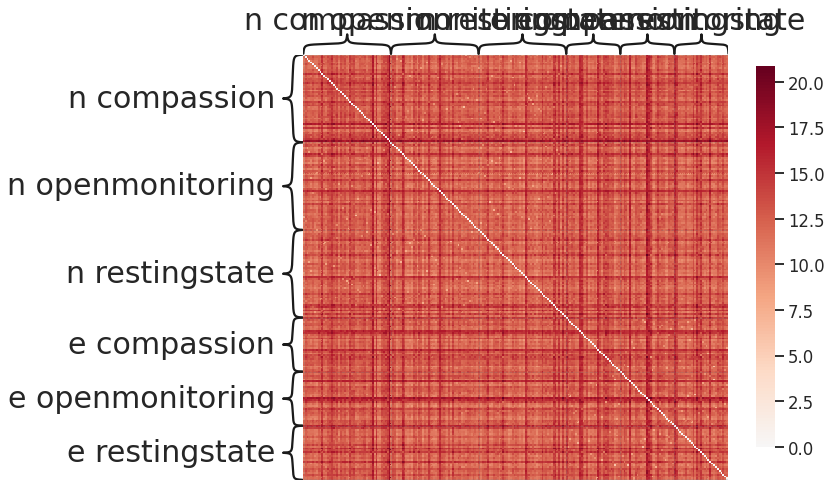

In [28]:
heatmap(pairwise_distances(groups[:,:,0].reshape(228,18715)),
        inner_hier_labels = [a + ' ' + b for a,b in labels])

In [31]:
X_dist_sums = pairwise_distances(groups[:,:,0].reshape(228,18715)).sum(axis=1)

subj_dict = defaultdict(list)
for sub, dist in zip(subjs, X_dist_sums):
    subj_dict[sub].append(dist / np.max(X_dist_sums))

(array([ 9., 16., 14.,  9., 11.,  4.,  6.,  2.,  0.,  5.]),
 array([1.98191681, 2.04363578, 2.10535474, 2.16707371, 2.22879268,
        2.29051164, 2.35223061, 2.41394958, 2.47566854, 2.53738751,
        2.59910648]),
 <a list of 10 Patch objects>)

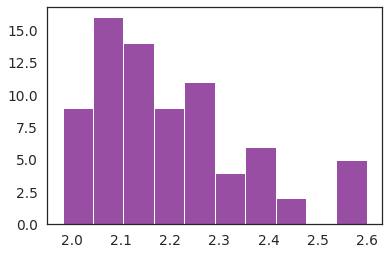

In [32]:
plt.hist([sum(x) for x in subj_dict.values()])

### Dmap vector check

In [94]:
datadir = Path("/mnt/ssd3/ronan/data")
dmap_dir = datadir / f"dmap_09-04_raw"

In [63]:
result = np.load(dmap_dir / "e_embedding_dense_res.sub-071.compassion.npy", allow_pickle=True).item()

In [64]:
result.keys()

dict_keys(['lambdas', 'vectors', 'n_components', 'diffusion_time', 'n_components_auto'])

In [72]:
X = result['vectors']

In [73]:
X.shape

(18715, 6)

In [74]:
np.linalg.norm(X, axis=0)

array([0.9999984 , 0.9999996 , 0.99999917, 0.9999996 , 1.0000001 ,
       1.0000001 ], dtype=float32)

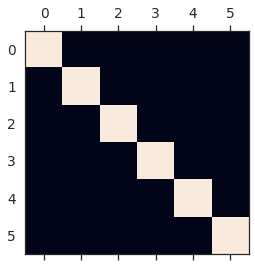

In [79]:
plt.matshow(X.T @ X)

In [102]:
for f in os.listdir(dmap_dir):
    if '_emb.' not in f:
        continue
    #X_emb = np.load(dmap_dir / "e_embedding_dense_emb.sub-071.compassion.npy", allow_pickle=True)#.item()
    X = np.load(dmap_dir / f, allow_pickle=True)
    X = X / np.linalg.norm(X, axis=0)
    print(np.sort(np.concatenate(X.T @ X))[-6])

0.02023901
0.039601382
0.020670613
0.068207875
0.05989759
0.0053136116
0.03067523
0.011570376
0.044573333
0.035824526
0.010904256
0.09057813
0.023207357
0.011286323
0.055545025
0.008068139
0.053050112
0.041962806
0.015786517
0.0059860833
0.021810666
0.027294856
0.061169486
0.03391848
0.025024217
0.008798506
0.03529019
0.0395587
0.12332555
0.021597106
0.041714575
0.002764952
0.13074753
0.038797468
0.041485168
0.017603733
0.01886197
0.06533301
0.081551656
0.013421089
0.0074226134
0.09096295
0.053191848
0.028176924
0.028261954
0.049179778
0.008929918
0.053265348
0.031942796
0.038726073
0.044428416
0.0497948
0.015918547
0.023797106
0.049170543
0.035349596
0.03148289
0.03292969
0.060593113
0.030366147
0.007601032
0.02456248
0.04143832
0.045151267
0.034687802
0.048704766
0.03428001
0.019618433
0.073621735
0.053957965
0.05066756
0.03931271
0.056445513
0.016249549
0.013194585
0.04264321
0.040500507
0.05669137
0.008655692
0.040471688
0.014063341
0.026556302
0.05494226
0.081497006
0.038672127
0.

In [85]:
X = X_emb / np.linalg.norm(X_emb, axis=0)

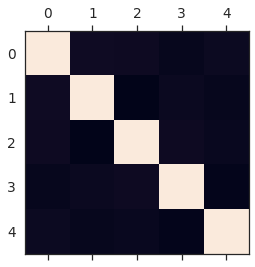

In [86]:
plt.matshow(X.T @ X)

In [101]:
np.sort([1,2,3,0])

array([0, 1, 2, 3])